# Youtube Channel Statistics

In [78]:
import pandas as pd
import numpy as np
import json
import re
from datetime import datetime

from apiclient.discovery import build

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

## Creating a Youtube service client
In order to call Youtube Data API to extract the required data, we need an **API Key**.<br/>
If you do not have one, follow the instruction on: https://developers.google.com/youtube/v3/getting-started

In [3]:
with open('./config.json') as f:
    config = json.load(f)
    
api_key = config['youtube']['api_key'] # or your api key

# Creating the client
client = build('youtube', 'v3', developerKey=api_key)

## Channel Information

In [4]:
channel_id = 'UClIsaGq7vBEW00ASqwQyzPw'

res = client.channels().list(
    part='snippet,contentDetails,statistics',
    id=channel_id
).execute()

In [5]:
def parse_date(datestring):
    return datetime.strptime(datestring, "%Y-%m-%dT%H:%M:%S.%fZ")

title = res['items'][0]['snippet']['title']
description = res['items'][0]['snippet']['description']
publishedAt = parse_date(res['items'][0]['snippet']['publishedAt'])
imgurl = res['items'][0]['snippet']['thumbnails']['default']['url']

all_playlist_id = res['items'][0]['contentDetails']['relatedPlaylists']['uploads']

viewCount = int(res['items'][0]['statistics']['viewCount'])
subscriberCount = int(res['items'][0]['statistics']['subscriberCount'])
videoCount = int(res['items'][0]['statistics']['videoCount'])

html = """
<table>
<tr><tr><td></td><td style="text-align:left"><img src="{0}"/></td></tr>
</td><td style="font-weight:bold">Channel</td><td style="text-align:left">{1}</td></tr>
</td><td style="font-weight:bold">Description</td><td style="text-align:left">{2}</td></tr>
</td><td style="font-weight:bold">Published at</td><td style="text-align:left">{3}</td></tr>
</td><td style="font-weight:bold">Subscribers</td><td style="text-align:left">{4:,}</td></tr>
</td><td style="font-weight:bold">Total View</td><td style="text-align:left">{5:,}</td></tr>
</td><td style="font-weight:bold">Videos</td><td style="text-align:left">{6:,}</td></tr>
</table>
""".format(imgurl, title, description, datetime.strftime(publishedAt, '%b %d, %Y'), 
           subscriberCount, viewCount, videoCount)

display(HTML(html))

,,Channel,BNK48,Description,BNK48 Official YouTube Channel,Published at,"Mar 16, 2016",Subscribers,"1,443,947",Total View,"295,451,480",Videos,290


## Retrieve all videos from the channel

In [6]:
def get_youtube_items(resource, part, **kwargs):
    """ 
    Call list() method of the designated resource param (e.g. playlistItems(), videos(), etc.)
    Then iterate through the entire paginated result set using pageToken parameter.
    Extract and accumulate the content inside the 'items' key.
    """
    res = resource.list(part=part, maxResults=50, **kwargs).execute()
    items = res['items']
    nextPageToken = res.get('nextPageToken','')
    while nextPageToken:
        res = resource.list(part=part, maxResults=50, 
                            pageToken=nextPageToken, **kwargs).execute()
        items = items + res['items']
        nextPageToken = res.get('nextPageToken','')
    return items

In [7]:
## Retrieve playlist items from the 'uploads' playlist
items = get_youtube_items(client.playlistItems(), part='snippet', playlistId=all_playlist_id)
print('Video count: {}'.format(len(items)))

Video count: 290


In [8]:
video_ids = []

for item in items:
    video_ids.append(item['snippet']['resourceId']['videoId'])

## Retrieve video information and statistics

In [9]:
BATCH_SIZE = 35

items = []
curr_idx = 0

# Get video info in batch
while curr_idx <= len(video_ids):
    ids = ','.join(video_ids[curr_idx:curr_idx+BATCH_SIZE])

    res = client.videos().list(
        part='snippet,contentDetails,statistics',
        id=ids
    ).execute()
    items = items + res['items']
    curr_idx = curr_idx + BATCH_SIZE

len(items)

290

In [10]:
def parse_duration(duration):
    """ Return seconds from the duration string in iso8601 format
        Simple conversion that does not cover all date parts of the ISO duration
    """
    m = re.search(r'(\d+)H', duration)
    dh = int(m.group(1)) if m else 0
    
    m = re.search(r'(\d+)M', duration)
    dm = int(m.group(1)) if m else 0
    
    m = re.search(r'(\d+)S', duration)
    ds = int(m.group(1)) if m else 0
    
    return dh*3600 + dm*60 + ds

In [62]:
videos = []
for v in items:
    videos.append({
        'Title': v['snippet']['title'].strip(),
#         'Description': v['snippet']['description'],
        'PublishedAt': parse_date(v['snippet']['publishedAt']),
        'Image': v['snippet']['thumbnails']['default']['url'],
        'Duration': parse_duration(v['contentDetails']['duration']),
        'View': int(v['statistics']['viewCount']),
        'Like': int(v['statistics']['likeCount']),
        'Dislike': int(v['statistics']['dislikeCount']),
        'Comment': int(v['statistics']['commentCount'])        
    })
videos = pd.DataFrame(videos)
videos = videos[['Title','Image','PublishedAt','Duration','View','Like','Dislike','Comment']]

videos['% Like'] = videos['Like']/videos['View']
videos['% Dislike'] = videos['Dislike']/videos['View']
videos['% Comment'] = videos['Comment']/videos['View']

# videos['Engagement'] = videos['Like'] + videos['Dislike'] + videos['Comment']

# Age in days
videos['Age'] = videos['PublishedAt'].apply(lambda x: (datetime.now() - x).days)

videos.head()

,Title,Image,PublishedAt,Duration,View,Like,Dislike,Comment,% Like,% Dislike,% Comment,Age
0,【PV】Yume e no Route หมื่นเส้นทาง (Special Olympics Thailand Collaboration ver.) / BNK48,https://i.ytimg.com/vi/rajKtMCNEGo/default.jpg,2018-10-27 07:48:22,241,189173,13369,63,938,0.070671,0.000333,0.004958,7
1,【PV】Yume e no Route หมื่นเส้นทาง / BNK48,https://i.ytimg.com/vi/su_ZmVg0nw0/default.jpg,2018-10-27 07:48:22,324,464007,31943,213,2400,0.068842,0.000459,0.005172,7
2,CHERPRANG VLOG EP05 : World Senbatsu in Japan / CherprangBNK48,https://i.ytimg.com/vi/pglJrYXlq_M/default.jpg,2018-10-25 06:02:54,941,74001,4108,36,640,0.055513,0.000486,0.008649,9
3,CHERPRANG VLOG EP04 : World Senbatsu in Japan / CherprangBNK48,https://i.ytimg.com/vi/jQGFFQRGhbE/default.jpg,2018-10-11 08:35:42,887,122536,5531,49,764,0.045138,0.000400,0.006235,23
4,「BNK48 6th Single Senbatsu General Election」Announcement / BNK48,https://i.ytimg.com/vi/QkYPSuLYXpM/default.jpg,2018-09-30 15:00:07,125,347701,12767,145,2807,0.036718,0.000417,0.008073,33


# Exploratory Data Analysis

## Top 10 - Most Views

In [13]:
pd.set_option('display.max_colwidth', -1)

th_props = [
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
]

styles = [
  dict(selector="th", props=th_props),
]

# Top 10 most viewed
df = videos.sort_values('View', ascending=False)[['Image','Title','View','% Like','% Dislike','% Comment','Age']].head(10)
df.index = np.arange(1, df.shape[0]+1)

# Render table in html
display(HTML(
    df.style
        .format({'View': '{:,}','Image':'<img src="{}"/>', '% Like': '{:.2%}', '% Comment': '{:.2%}', '% Dislike': '{:.2%}'})
        .set_table_styles(styles)
        .set_properties(**{'text-align':'left'})
        .render()
))

,Image,Title,View,% Like,% Dislike,% Comment,Age
1,,【MV Full】Koisuru Fortune Cookie คุกกี้เสี่ยงทาย / BNK48,"155,406,222",0.43%,0.04%,0.08%,349
2,,【MV Full】RIVER / BNK48,"16,582,787",1.38%,0.09%,0.29%,186
3,,【MV Full】Kimi wa Melody เธอคือ…เมโลดี้ / BNK48,"12,648,326",1.83%,0.06%,0.32%,48
4,,【MV Full】Tsugi no Season ฤดูใหม่ / BNK48,"11,489,716",1.43%,0.07%,0.25%,91
5,,【MV Full】Shonichi วันแรก / BNK48,"8,129,689",1.63%,0.05%,0.17%,207
6,,【MV Full】Anata to Christmas Eve คำสัญญาแห่งคริสต์มาสอีฟ / BNK48,"4,222,391",1.73%,0.05%,0.27%,249
7,,【Audio Full】Shonichi วันแรก / BNK48,"3,073,444",1.48%,0.03%,0.15%,219
8,,BNK48 SHOW EP13 (Director's Cut) Break02,"2,111,206",0.65%,0.03%,0.04%,333
9,,BNK48 Show EP12 Break02,"1,877,891",0.76%,0.03%,0.09%,348
10,,BNK48 Senpai ep.05 (Part 1),"1,532,285",0.71%,0.02%,0.05%,602


## Top 10 - % Like

In [14]:
df = videos.sort_values('% Like', ascending=False)[['Image','Title','% Like','View','% Dislike','% Comment','Age']].head(10)
df.index = np.arange(1, df.shape[0]+1)

# Render table in html
display(HTML(
    df.style
        .format({'View': '{:,}','Image':'<img src="{}"/>', '% Like': '{:.2%}', '% Comment': '{:.2%}', '% Dislike': '{:.2%}'})
        .set_table_styles(styles)
        .set_properties(**{'text-align':'left'})
        .render()
))

,Image,Title,% Like,View,% Dislike,% Comment,Age
1,,【PV】Yume e no Route หมื่นเส้นทาง (Special Olympics Thailand Collaboration ver.) / BNK48,7.07%,"189,173",0.03%,0.50%,6
2,,【PV】Yume e no Route หมื่นเส้นทาง / BNK48,6.88%,"464,007",0.05%,0.52%,6
3,,KhunKai’s Kitchen EP08 : Ice Cream Homemade / KaimookBNK48,6.25%,"7,780",0.17%,0.30%,61
4,,KhunKai’s Kitchen EP04 : Rainbow Pancake / KaimookBNK48,6.13%,"18,509",0.09%,0.43%,61
5,,KhunKai’s Kitchen EP06 : Christmas Cookies / KaimookBNK48,6.03%,"10,691",0.07%,0.35%,61
6,,【MV Teaser】Kimi wa Melody เธอคือ…เมโลดี้ / BNK48,5.93%,"380,236",0.05%,0.76%,63
7,,KhunKai’s Kitchen EP09 : S’more / KaimookBNK48,5.72%,"11,902",0.13%,0.37%,61
8,,KhunKai’s Kitchen EP03 : Strawberry Panna Cotta / KaimookBNK48,5.71%,"21,429",0.07%,0.44%,61
9,,CHERPRANG VLOG EP05 : World Senbatsu in Japan / CherprangBNK48,5.55%,"74,001",0.05%,0.86%,9
10,,KhunKai’s Kitchen EP05 : Santa Claus Jelly / KaimookBNK48,5.52%,"13,393",0.07%,0.30%,61


## Top 10 - % Comment

In [15]:
df = videos.sort_values('% Comment', ascending=False)[['Image','Title','% Comment','View','% Like','% Dislike','Age']].head(10)
df.index = np.arange(1, df.shape[0]+1)

# Render table in html
display(HTML(
    df.style
        .format({'View': '{:,}','Image':'<img src="{}"/>', '% Like': '{:.2%}', '% Comment': '{:.2%}', '% Dislike': '{:.2%}'})
        .set_table_styles(styles)
        .set_properties(**{'text-align':'left'})
        .render()
))

,Image,Title,% Comment,View,% Like,% Dislike,Age
1,,「Kimi wa Melody –เธอคือ...เมโลดี้–」Senbatsu Members Announcement / BNK48,0.99%,"810,157",3.75%,0.06%,76
2,,BNK48 5th Single「BNK Festival」Senbatsu Members Announcement / BNK48,0.95%,"264,729",3.79%,0.05%,33
3,,CHERPRANG VLOG EP05 : World Senbatsu in Japan / CherprangBNK48,0.86%,"74,001",5.55%,0.05%,9
4,,「Yume e no Route –หมื่นเส้นทาง–」Senbatsu Members Announcement / BNK48,0.81%,"383,160",3.91%,0.05%,75
5,,「BNK48 6th Single Senbatsu General Election」Announcement / BNK48,0.81%,"347,701",3.67%,0.04%,33
6,,"Video Messages「Koisuru Fortune Cookie 100,000,000 Views」 / BNK48",0.79%,"168,623",5.50%,0.05%,215
7,,【MV Teaser】Kimi wa Melody เธอคือ…เมโลดี้ / BNK48,0.76%,"380,236",5.93%,0.05%,63
8,,「Tsugi no Season –ฤดูใหม่–」Senbatsu Members Announcement / BNK48,0.72%,"270,966",4.81%,0.09%,108
9,,Shonichi The Stories / BNK48,0.69%,"762,308",4.95%,0.07%,215
10,,"「RIVER」Senbatsu Announcement from Tao Kae Noi Presents BNK48 1st Concert ""STARTO"" / BNK48",0.63%,"381,133",2.85%,0.05%,216


## Video Statistics

In [204]:
videos.describe()

,Duration,View,Like,Dislike,Comment,% Like,% Dislike,% Comment,Age
count,290.000000,2.900000e+02,290.000000,290.000000,290.00000,290.000000,290.000000,290.000000,290.000000
mean,634.348276,1.018780e+06,8990.906897,423.172414,1324.37931,0.017312,0.000342,0.001660,366.837931
std,1098.641325,9.219139e+06,45291.441608,3890.908268,8177.01432,0.013887,0.000340,0.001769,191.181822
min,16.000000,7.780000e+03,168.000000,6.000000,8.00000,0.003829,0.000064,0.000206,7.000000
25%,184.250000,6.902325e+04,1153.000000,20.000000,88.25000,0.007004,0.000172,0.000543,232.750000
50%,511.000000,2.256255e+05,2037.500000,46.000000,168.00000,0.012652,0.000234,0.000947,362.000000
75%,704.500000,4.252240e+05,4776.000000,102.750000,432.25000,0.021230,0.000438,0.002074,551.000000
max,11089.000000,1.554062e+08,669125.000000,63791.000000,120454.00000,0.070671,0.004412,0.009947,950.000000


## Feature Distributions

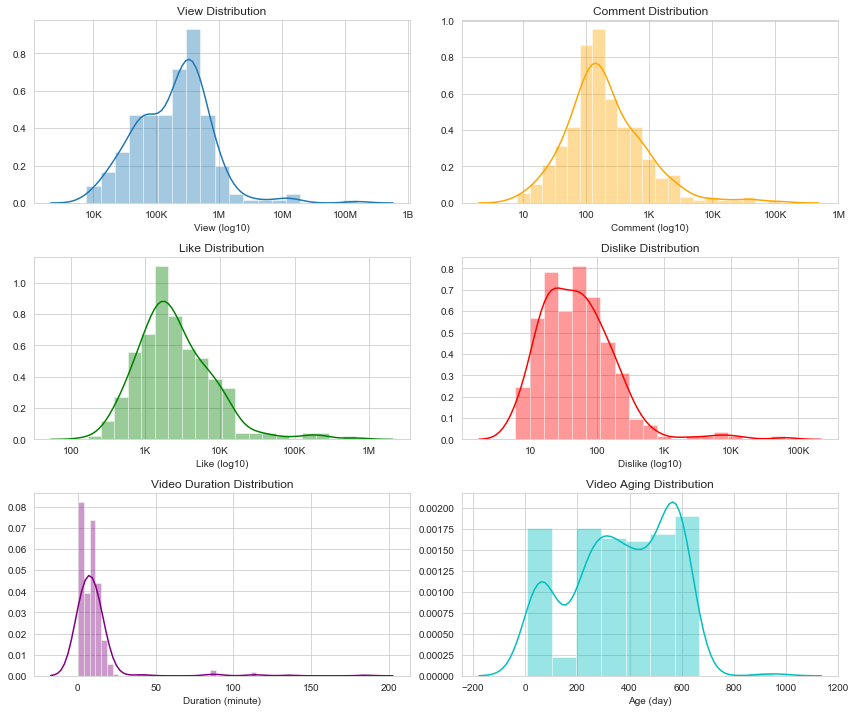

In [255]:
sns.set_style('whitegrid')

e10_labels = ['1','10','100','1K','10K','100K','1M','10M','100M','1B','10B']

# Subplots
f, axes = plt.subplots(3,2, figsize=(12,10))

# View histogram
ax = sns.distplot(np.log10(videos['View']), axlabel='View (log10)', ax=axes[0,0]);
ax.set_title('View Distribution')
ax.set_xticks(np.arange(4,10))
ax.set_xticklabels(e10_labels[4:10])

# Comment histogram
ax = sns.distplot(np.log10(videos['Comment']), axlabel='Comment (log10)', ax=axes[0,1], color='orange');
ax.set_title('Comment Distribution')
ax.set_xticks(np.arange(1,7))
ax.set_xticklabels(e10_labels[1:7])

# Like histogram
ax = sns.distplot(np.log10(videos['Like']), axlabel='Like (log10)', ax=axes[1,0], color='green');
ax.set_title('Like Distribution')
ax.set_xticks(np.arange(2,7))
ax.set_xticklabels(e10_labels[2:7])

# Dislike histogram
ax = sns.distplot(np.log10(videos['Dislike']), axlabel='Dislike (log10)', ax=axes[1,1], color='red');
ax.set_title('Dislike Distribution')
ax.set_xticks(np.arange(1,6))
ax.set_xticklabels(e10_labels[1:6])

# Duration histogram
ax = sns.distplot(videos['Duration']/60, axlabel='Duration (minute)', ax=axes[2,0], color='purple');
ax.set_title('Video Duration Distribution')
# ax.set_xticks(np.arange(1,6))
# ax.set_xticklabels(e10_labels[1:6])

# Age histogram
ax = sns.distplot(videos['Age'], axlabel='Age (day)', ax=axes[2,1], color='c');
ax.set_title('Video Aging Distribution')
# ax.set_xticks(np.arange(1,6))
# ax.set_xticklabels(e10_labels[1:6])

plt.tight_layout();

### How likely do viewers interact with the videos?

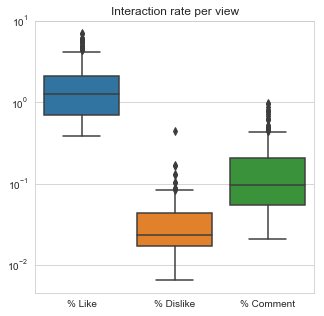

In [256]:
plt.figure(figsize=(5,5))
sns.boxplot(data=videos[['% Like','% Dislike','% Comment']]*100)
plt.title('Interaction rate per view')
plt.yscale('log');

Viewers tend to give Likes more than Comments and Dislikes respectively.

## Correlation

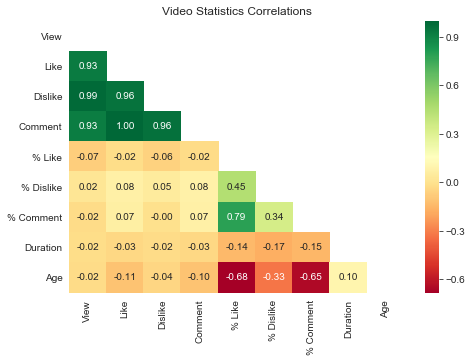

In [253]:
cols = ['View','Like','Dislike','Comment','% Like','% Dislike', '% Comment', 'Duration', 'Age']
corr = videos[cols].corr()

plt.figure(figsize=(7.5,5))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr, mask=mask, cmap='RdYlGn', annot=True, fmt='.2f')
ax.set_title('Video Statistics Correlations');

### Views vs. Likes / Dislikes / Comments relation

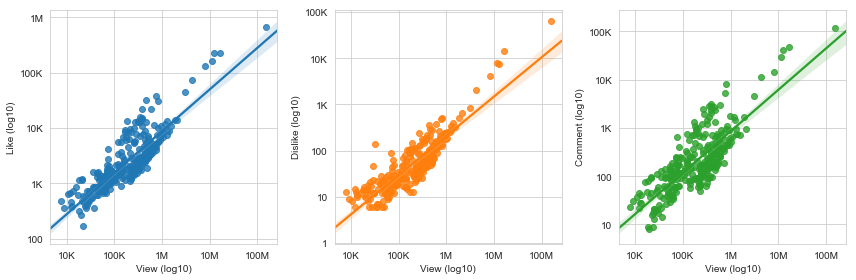

In [283]:
df = pd.DataFrame({
    'View (log10)': np.log10(videos['View']),
    'Like (log10)': np.log10(videos['Like']),
    'Dislike (log10)': np.log10(videos['Dislike']),
    'Comment (log10)': np.log10(videos['Comment'])
})

# Subplots
f, axes = plt.subplots(ncols=3, figsize=(12,4))

# View & Like
ax = sns.regplot(x='View (log10)', y='Like (log10)', data=df, ax=axes[0])
ax.set_xticks(np.arange(4,9))
ax.set_xticklabels(e10_labels[4:9])
ax.set_yticks(np.arange(2,7))
ax.set_yticklabels(e10_labels[2:7])

# View & Dislike
ax = sns.regplot(x='View (log10)', y='Dislike (log10)', data=df, ax=axes[1])
ax.set_xticks(np.arange(4,9))
ax.set_xticklabels(e10_labels[4:9])
ax.set_yticks(np.arange(0,6))
ax.set_yticklabels(e10_labels[0:6])

# View & Comment
ax = sns.regplot(x='View (log10)', y='Comment (log10)', data=df, ax=axes[2])
ax.set_xticks(np.arange(4,9))
ax.set_xticklabels(e10_labels[4:9])
ax.set_yticks(np.arange(1,6))
ax.set_yticklabels(e10_labels[1:6])

plt.tight_layout();

- Views, Likes, Dislikes, and Comments are highly positive-correlated among themselves
- More views, more interations (like/dislike/comment)

### Feedback behavior on older/later released videos
**Age** variable measures how long the video has been released until now in days.

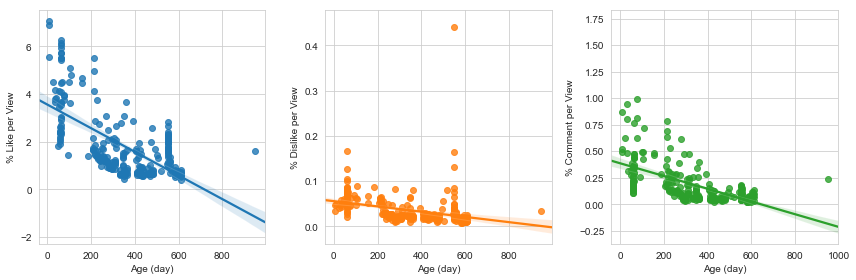

In [290]:
df = pd.DataFrame({
    'Age (day)': videos['Age'],
    '% Like per View' : videos['% Like']*100,
    '% Dislike per View' : videos['% Dislike']*100,
    '% Comment per View' : videos['% Comment']*100
})

f, axes = plt.subplots(ncols=3, figsize=(12,4))
sns.regplot(x='Age (day)', y='% Like per View', data=df, ax=axes[0])
sns.regplot(x='Age (day)', y='% Dislike per View', data=df, ax=axes[1])
sns.regplot(x='Age (day)', y='% Comment per View', data=df, ax=axes[2])
plt.tight_layout();

- Age vs. % Like, % Comment, and % Dislike have negative correlations while being against % Dislike is less
- To put it more intuitively, the later released videos tend to attract more likes and comments relatively to the view amount than the older videos
- Meaning that the channel is doing better in gaining positive feedback (% of like per view)